In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import dar_estilo_visual

In [2]:
import statsmodels.api as sm
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder

In [3]:
dar_estilo_visual()
df_modelo = pd.read_csv("cleaned_data/limpio_inicial.csv")

In [4]:
cols_retraso = [f'RETRASO_PAGO_ESTADO_t-{i}' for i in range(6)]
cols_deuda = [f'DEUDA_MES_t-{i}' for i in range(6)]
cols_pago = [f'PAGO_MES_t-{i}' for i in range(6)]
target = "default payment next month"

## Discretización de Edad en Deciles

De acuerdo con el enunciado, se creará una nueva variable la cual divide a la población en 10 grupos ordenados de igual tamaño de acuerdo con la edad.

In [5]:
# Hallar los deciles de acuerdo a la edad.
age_deciles = np.percentile(df_modelo["AGE"], [10*i for i in range(0,11)])
# Segmentar a la población en deciles de edad
df_modelo["AGE_DECILES"] = pd.cut(df_modelo["AGE"], age_deciles)

Ahora analizaremos la relación de la anterior segmentación de la edad en deciles con respecto a la variable objetivo

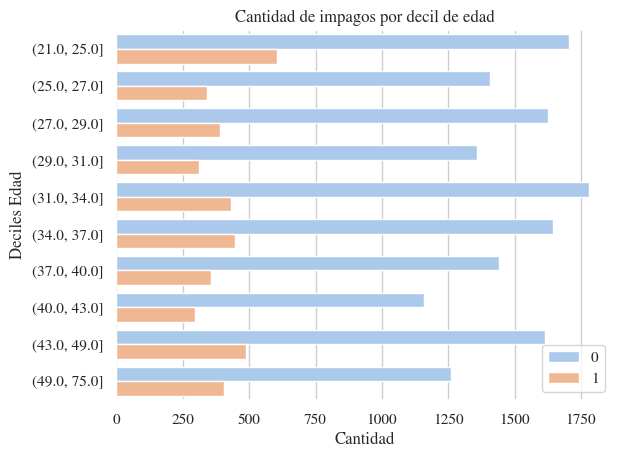

In [6]:
# Cantidad de impagos por decil
sns.countplot(data = df_modelo, y="AGE_DECILES", hue=target, palette="pastel")
plt.ylabel("Deciles Edad")
plt.xlabel("Cantidad")
plt.legend()
plt.title("Cantidad de impagos por decil de edad")
plt.show()

Podemos observar que en el decil donde más se presentarán impagos el próximo mes es en el de los clientes entre 21 y 25 años de edad.

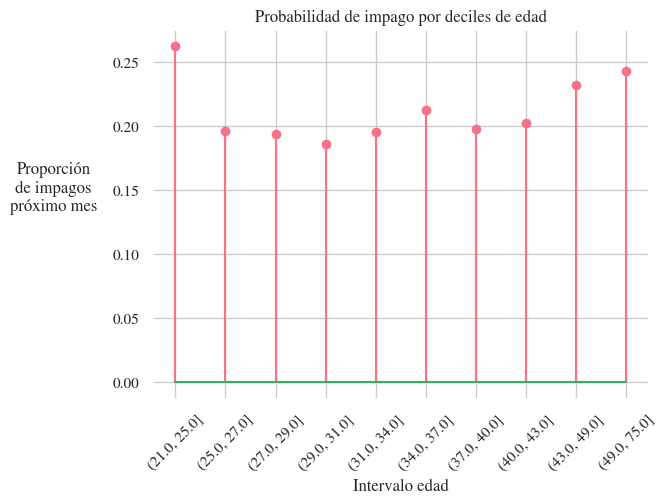

In [7]:
# Calcular la proporción de impagos en cada decil
prop_impagos = df_modelo.groupby("AGE_DECILES")[target].value_counts(normalize=True)
prop_impagos = prop_impagos.reset_index() 
prop_impagos = prop_impagos[prop_impagos[target]==1]

# Visualizar un lolipop con la proporción en cada decil
my_range=range(0,len(prop_impagos.index))
fig, ax = plt.subplots()
plt.stem(prop_impagos['proportion'])
plt.xticks(my_range, prop_impagos["AGE_DECILES"], rotation=45)
plt.xlabel("Intervalo edad")
plt.ylabel("Proporción\nde impagos\npróximo mes", rotation=0)
ax.yaxis.set_label_coords(-0.2,0.5)
plt.title("Probabilidad de impago por deciles de edad")
plt.show()

Mediante la anterior gráfica, podemos conlcuir que además existe una mayor probabilidad de fallar el pago en el próximo mes en los clientes entre 21 y 25 años de edad.

Concluimos que la edad es una característica importante y puede ser benificioso para el modelo aplicar una discretización en deciles.

## Correlación entre variables monetarias 

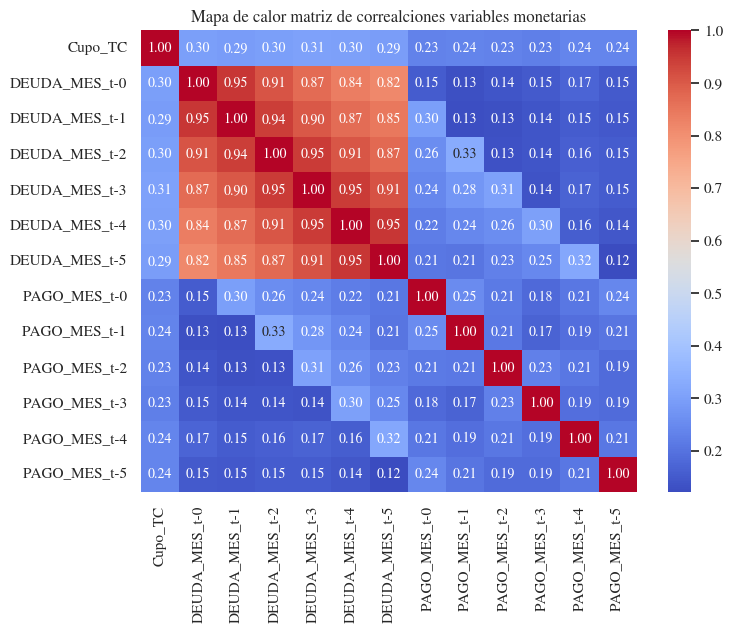

In [8]:
# Calcular matriz de correlación, especificando variables monetarias
corr_matrix = df_modelo[["Cupo_TC"]+cols_deuda+cols_pago].corr()
# Create correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Mapa de calor matriz de correalciones variables monetarias')
plt.show()

Observamos que: 
- Existe una alta correlación entre los montos de las deudas de los últimos meses. Para reducir dimensionalidad, puede ser adecuado crear una variable que resulte de agregar las deudas de los últimos meses para cada cliente, como promedio, media o suma.
- Existe una correlación mayor a $0.31$ entre el monto de pago en un determinado mes y la deuda del mes inmediantamente anterior. Por lo tanto, la variable del monto de deuda del mes $t$ puede ser decisiva para el comportamiento del pago en el mes $t+1$.

In [9]:
# Creacion de la variable promedio de deuda
df_modelo["PROMEDIO_DEUDA"] = df_modelo[cols_deuda].mean(axis=1)

## Cupo total

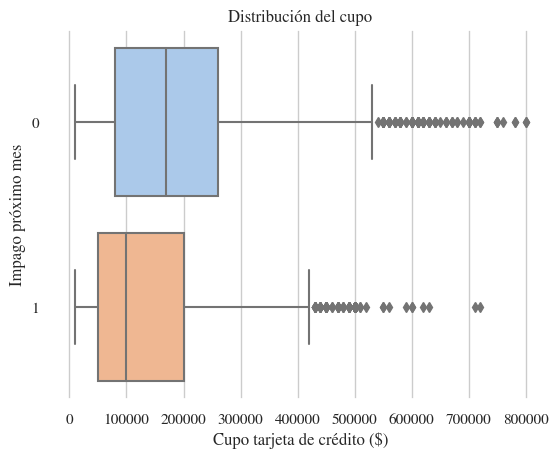

In [10]:
sns.boxplot(data=df_modelo, x="Cupo_TC", y=target, orient="h", palette='pastel')
plt.xlabel("Cupo tarjeta de crédito ($)")
plt.ylabel("Impago próximo mes")
plt.title("Distribución del cupo")
plt.show()

Podemos observar que en general los clientes que cometerán impago el próximo mes tienen un cupo total de tarjeta de crédito menor a los que pagarán puntualmente. La mediana de cupo para clientes de impago es $\$100.000$, mientras que, la mediana de cupo para clientes puntuales está cerca a $\$180.000$

**Discretización del cupo en deciles** 

In [11]:
cupo_deciles = np.percentile(df_modelo["Cupo_TC"], [10*i for i in range(0,11)])
df_modelo["CUPO_DECILES"] = pd.cut(df_modelo["Cupo_TC"], cupo_deciles)

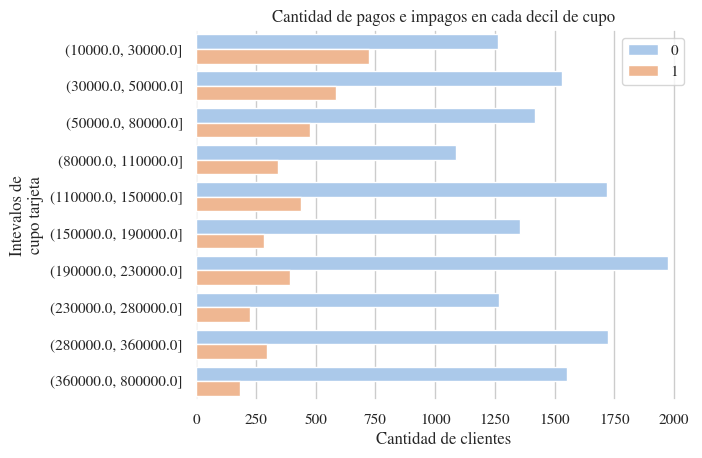

In [12]:
sns.countplot(data=df_modelo, y="CUPO_DECILES", hue=target, palette="pastel")
plt.xlabel("Cantidad de clientes")
plt.ylabel("Intevalos de\ncupo tarjeta")
plt.legend()
plt.title("Cantidad de pagos e impagos en cada decil de cupo")
plt.show()

Mendiante esta gráfica podemos observar que la mayoría de clientes impagos para el próximo mes se encuentran en el primer decil, además, conforme aumenta el cupo de la tarjeta, la cantidad de impagos disminuye. Usualmente el cupo de la tarjeta se otroga de forma directamente proporcional a la capacidad adquisitiva de un cliente, por lo tanto, la probabilidad de impago es mayor cuando se tiene menos capacidad adquisitiva.

Construimos una nueva variable que calcula el cociente entre el promedio de la deuda y el cupo de la tarjeta.

In [13]:
df_modelo["DEUDA/CUPO"] = df_modelo["PROMEDIO_DEUDA"] / df_modelo["Cupo_TC"]

## Regresión logística preliminar

Con el fin de analizar la importancia de cada una de las variables explicativas con respecto a la variable objetivo, implementamos de forma preliminar una regresión logística ajustada a todos los 19 mil registros de la muestra. Con esto no pretendemos construir como tal modelo predictivo y reportar su desempeño, por el contrario, se quiere conocer de forma preliminara la utilidad de las variables construidas y la posible afectación de las variables en el modelo. 

In [14]:
ordinales = ["CUPO_DECILES", "AGE_DECILES"]
nominales = ["EDUCATION", "MARRIAGE", "SEX"]

In [15]:
# Codificar variables nominales usando variables dummy
onehot_encoder = OneHotEncoder(cols=nominales)
df_modelo = onehot_encoder.fit_transform(df_modelo)

In [16]:
# Codificar variables ordinales usando enteros consecutivos y preservando el orden natural
ordinal_encoder = OrdinalEncoder(cols=ordinales)
df_modelo = ordinal_encoder.fit_transform(df_modelo)

In [17]:
# Se definen las variables explicativas y la variable objetivo
X = df_modelo.drop(columns=["Cupo_TC","AGE", "PROMEDIO_DEUDA", "DEUDA/CUPO",target])
y = df_modelo[target]

In [18]:
# Se ajusta una regresión logística
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.448432
         Iterations 7


In [19]:
# Resumen de la regresión
print(log_reg.summary())

                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                19095
Model:                                  Logit   Df Residuals:                    19067
Method:                                   MLE   Df Model:                           27
Date:                        Mon, 05 Jun 2023   Pseudo R-squ.:                  0.1348
Time:                                07:24:12   Log-Likelihood:                -8562.8
converged:                               True   LL-Null:                       -9896.9
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
SEX_1                      -0.6458   2.37e+05  -2.72e-06      1.000   -4.65e+05    4.65e+05
SEX_2                      -

De acuerdo con la regresión, al analizar los p-values, que indican la confianza de que los pesos asociados a las variables sean 0, deducimos que:
- Las variables SEX, EDUCATION, MARRIAGE no tienen una relación significativa con el impago del próximo mes. 
- La deuda en el mes 0 tiene un alto impacto y es inversamente proporcional a la probabilidad de pagar a tiempo el próximo mes. 
- El estado de retraso del mes acutual y el anterior son los más importantes.
- El age en deciles y el cupo en deciles tienen un pvalue un poco alto pero por debajo de 0.5

Sin embargo, el modelo presenta un ajuste $R^2-ajustado$ de $0,13$, por lo tanto aún hay muchas oportunidades de mejora.

Ahora, volvemos a ajustar la regresión logística adicionando las nuevas variables "Promedio_deuda" y "Deuda/Cupo" en vez de las deudas en t-5, t-4 y t-3

In [22]:
X = df_modelo.drop(columns=["Cupo_TC","AGE", "DEUDA_MES_t-5", "DEUDA_MES_t-4", "DEUDA_MES_t-3",target])
y = df_modelo[target]
# Se ajusta una regresión logística
log_reg = sm.Logit(y, X).fit()
# Resumen de la regresión
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.448348
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                19095
Model:                                  Logit   Df Residuals:                    19068
Method:                                   MLE   Df Model:                           26
Date:                        Mon, 05 Jun 2023   Pseudo R-squ.:                  0.1350
Time:                                07:28:40   Log-Likelihood:                -8561.2
converged:                               True   LL-Null:                       -9896.9
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
SEX_1             

El modelo no mejora drásticamente, sin embargo, profundizaremos en la importancia de las características en la experimentación con otros modelos.

## Exportación

In [24]:
# Finalemnte, Exportamos los datos con las nuevas características y transformaciones aplicadas
df_modelo.to_csv("cleaned_data/data_preparada.csv", index=False)